## Topic Modeling LSA/I, probabilistic LSA / NMF and LDA

### Imports

In [2]:
import warnings
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# gensim for alternative models
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

c:\users\rujjn\anaconda3\envs\spacy\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\users\rujjn\anaconda3\envs\spacy\lib\site-packages\scipy\sparse\sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
% matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [76]:
docs = pd.read_pickle('training_set.pkl')

topic_dict = {'topic':{1: 'computers', 2: 'censorship', 3: 'cyclist', 4: 'hibiscus', 5: 'mood', 6: 'dirigibles', 7: 'patience', 8: 'laughter'}}

docs.replace(topic_dict, inplace=True)

essay_2 = docs[docs.topic == 'censorship']

In [6]:
essay_2.target_score.value_counts(normalize=True)

4   0.43
3   0.42
2   0.09
5   0.04
1   0.01
6   0.00
Name: target_score, dtype: float64

In [18]:
train_docs, test_docs = train_test_split(essay_2, 
                                         stratify=essay_2.target_score, 
                                         test_size=0.1, 
                                         random_state=42)

In [19]:
train_docs.shape, test_docs.shape

((1620, 33), (180, 33))

In [20]:
pd.Series(test_docs.target_score).value_counts()

4    78
3    76
2    15
5     8
1     2
6     1
Name: target_score, dtype: int64

## Latent Dirichlet Allocation

### PyLDAVis

LDAvis helps you interpret LDA results by answer 3 questions:

1. What is the meaning of each topic?
2. How prevalent is each topic?
3. How do topics relate to each other?

#### Refit using all data

In [37]:
vectorizer = CountVectorizer(max_df=.5, 
                             min_df=5,
                             stop_words='english',
                             max_features=2000)
dtm = vectorizer.fit_transform(essay_2.essay)

In [38]:
lda_all = LatentDirichletAllocation(n_components=6,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=10,
                                    random_state=42,
                                    verbose=1)
lda_all.fit(dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 701.0280
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 692.4798
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500
iteration: 30 of max_iter: 500, perplexity: 689.8614
iteration: 31

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=500, mean_change_tol=0.001,
             n_components=6, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

#### Lambda

- **$\lambda$ = 0**: how probable is a word to appear in a topic - words are ranked on lift P(word | topic) / P(word)
- **$\lambda$ = 1**: how exclusive is a word to a topic -  words are purely ranked on P(word | topic)

The ranking formula is $\lambda * P(\text{word} \vert \text{topic}) + (1 - \lambda) * \text{lift}$

User studies suggest $\lambda = 0.6$ works for most people.

In [39]:
prepare(lda_all, dtm, vectorizer)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
3      0.06  0.18       1        1 23.32
0      0.09  0.00       2        1 21.93
5      0.12  0.10       3        1 18.76
4     -0.01 -0.09       4        1 17.68
2      0.07 -0.22       5        1 10.96
1     -0.32  0.03       6        1  7.36, topic_info=     Category     Freq           Term    Total  loglift  logprob
term                                                            
296   Default 2,745.00       children 2,745.00    30.00    30.00
230   Default 1,103.00          caps2 1,103.00    29.00    29.00
231   Default   731.00          caps3   731.00    28.00    28.00
932   Default 1,678.00           kids 1,678.00    27.00    27.00
524   Default   823.00           dont   823.00    26.00    26.00
232   Default   608.00          caps4   608.00    25.00    25.00
292   Default 1,267.00          child 1,267.00    24.00    24.00
131   Default 1,339.00            bad 1,339.00    23.00    23.00
268   Default 1,712.00     censorship 1,712.00    22.00    22.00
523   Default 1,771.00            don 1,771.00    21.00    21.00
1247  Default 1,306.00        parents 1,306.00    20.00    20.00
1717  Default   607.00          stuff   607.00    19.00    19.00
1272  Default 1,679.00         person 1,679.00    18.00    18.00
1069  Default 1,483.00       material 1,483.00    17.00    17.00
233   Default   375.00          caps5   375.00    16.00    16.00
42    Default   912.00            age   912.00    15.00    15.00
1578  Default 1,300.00          shelf 1,300.00    14.00    14.00
1539  Default   592.00        section   592.00    13.00    13.00
1227  Default   356.00  organization1   356.00    12.00    12.00
487   Default 1,464.00      different 1,464.00    11.00    11.00
1070  Default 1,343.00      materials 1,343.00    10.00    10.00
1780  Default   394.00          thats   394.00     9.00     9.00
1188  Default   561.00       offended   561.00     8.00     8.00
28    Default   529.00          adult   529.00     7.00     7.00
940   Default 1,474.00           know 1,474.00     6.00     6.00
698   Default   531.00        freedom   531.00     5.00     5.00
1794  Default   939.00          thing   939.00     4.00     4.00
1973  Default 1,324.00          world 1,324.00     3.00     3.00
1115  Default 1,806.00         month1 1,806.00     2.00     2.00
1584  Default 1,748.00        shelves 1,748.00     1.00     1.00
...       ...      ...            ...      ...      ...      ...
230    Topic6   867.79          caps2 1,103.11     2.37    -2.78
1227   Topic6   272.26  organization1   356.23     2.34    -3.94
977    Topic6    21.15         letter    24.73     2.45    -6.49
1273   Topic6   190.84        person1   305.77     2.14    -4.29
1169   Topic6    64.42           num2    88.03     2.30    -5.38
203    Topic6    37.42        brother    49.46     2.33    -5.92
293    Topic6    31.81      childeren    41.55     2.34    -6.08
178    Topic6    48.86          black    76.14     2.17    -5.65
1275   Topic6    28.97        person3    38.59     2.32    -6.18
1274   Topic6    71.48        person2   126.72     2.04    -5.27
194    Topic6    36.01            boy    51.39     2.25    -5.96
1994   Topic6    74.87           year   145.44     1.94    -5.23
1966   Topic6   119.47           word   281.04     1.75    -4.76
1168   Topic6   126.65           num1   348.14     1.60    -4.70
1064   Topic6    62.70            man   127.71     1.90    -5.40
725    Topic6    59.06           girl   117.71     1.92    -5.46
1203   Topic6    99.22            old   292.84     1.53    -4.95
1045   Topic6    81.91           love   211.60     1.66    -5.14
1967   Topic6   128.39          words   512.58     1.22    -4.69
1995   Topic6    74.52          years   209.86     1.57    -5.23
437    Topic6    88.81            day   307.70     1.37    -5.06
1517   Topic6   106.03           said   464.98     1.13    -4.88
480    Topic6    90.23            did   357.03     1.2

### Topics as WordClouds

In [40]:
topics_prob = lda_all.components_ / lda_all.components_.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=vectorizer.get_feature_names(),
                      columns=topic_labels)

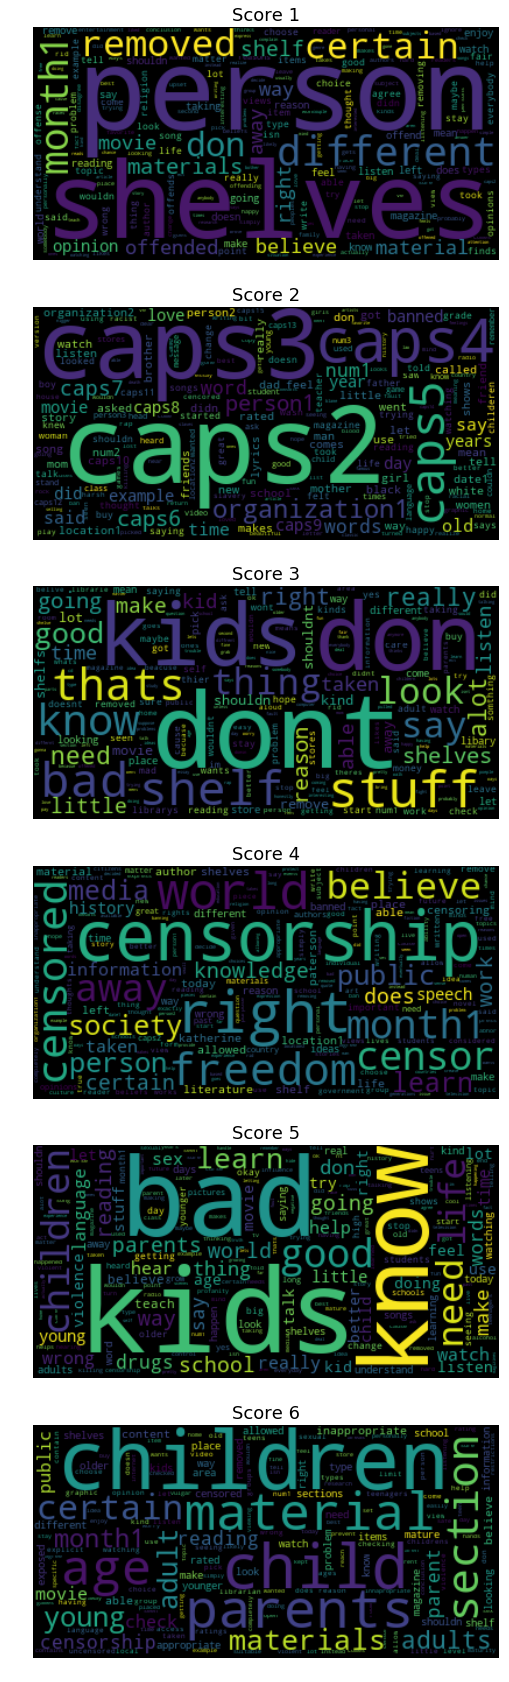

In [41]:
w = WordCloud()
fig, axes = plt.subplots(nrows=6, figsize=(15, 30))
axes = axes.flatten()
for t, (topic, freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=18)
    axes[t].axis('off')

### Visualize topic-word assocations per document

In [43]:
dtm_ = pd.DataFrame(data=lda_all.transform(dtm),
                    columns=topic_labels,
                    index=essay_2.target_score)

In [45]:
color_dict = OrderedDict()
color_dict['Score 1'] = {'color': 'white', 'on_color': 'on_blue'}
color_dict['Score 2'] = {'color': 'white', 'on_color': 'on_green'}
color_dict['Score 3'] = {'color': 'white', 'on_color': 'on_red'}
color_dict['Score 4'] = {'color': 'white', 'on_color': 'on_magenta'}
color_dict['Score 5'] = {'color': 'blue', 'on_color': 'on_yellow'}
color_dict['Score 6'] = {'color': 'blue', 'on_color': 'on_magenta'}

In [52]:
dtm_['article'] = essay_2.essay.values
# dtm_['heading'] = docs.heading.values
sample = dtm_[dtm_[topic_labels].gt(.03).all(1)]
sample

,Score 1,Score 2,Score 3,Score 4,Score 5,Score 6,article
target_score,,,,,,,
4,0.37,0.12,0.07,0.17,0.11,0.18,"Many people go to libraries; such as children,..."
4,0.39,0.05,0.22,0.05,0.21,0.07,To begin with I feel everyone should admire th...
4,0.22,0.11,0.18,0.06,0.23,0.20,"Everyone has a right to read, listen, or watch..."
4,0.15,0.06,0.21,0.14,0.08,0.37,"Some people ask, '@CAPS1 books should be censo..."
3,0.21,0.15,0.06,0.23,0.20,0.15,In my own personal opinion this letter to the ...
4,0.08,0.04,0.10,0.08,0.51,0.20,I believe that censorship is a very debatable ...
4,0.58,0.03,0.11,0.09,0.09,0.09,'Book or no Book?' Certain studies have shown ...
3,0.22,0.05,0.06,0.08,0.44,0.15,I do not feel these types of things should not...
4,0.13,0.03,0.09,0.31,0.10,0.35,A @CAPS1 is a place for people of all ages to ...


In [55]:
colored_text = []
for word in sample.iloc[0, 6].split():
    try:
        topic = topics.loc[word.strip().lower()].idxmax()
        colored_text.append(colored(word, **color_dict[topic]))
    except:
        colored_text.append(word)
#    ®
print(' '.join([colored(k, **v) for k, v in color_dict.items()]))
print('\n',sample.iloc[0, 6], '\n')
text = ' '.join(colored_text)
print(text)

Score 1 Score 2 Score 3 Score 4 Score 5 Score 6

 Many people go to libraries; such as children, parents, and grandparents. I have come to realize that their purpose for going to this community loving place is to find peace and quiet. Some don't even go there for the books. They will engage in music, magazine, enjoy a cup of coffee, or simply get on the internet. Now some people argue that some of the books, music, and movies in libraries are inappropriate or offensive, but does that mean the libraries should have to get rid of them?     These materials people find offensive have no reason to be banned. First of all, the libraries will lose customers. There is a majority of people in the world who really like listening to rap or @CAPS1&@CAPS2. It's hard to find that kind of music without cuss words or sexual inuendo. Even I will listen to that type of stuff occasionally just so that I can have a cool beat stuck in my head for a while. Plus, when you are in a library and listening to mu

## LDA with gensim

### Using `CountVectorizer` Input

In [56]:
max_df = .2
min_df = 3
max_features = 2000

# used by sklearn: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py
stop_words = pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', 
                         header=None, 
                         squeeze=True).tolist()

In [57]:
vectorizer = CountVectorizer(max_df=max_df, 
                             min_df=min_df, 
                             stop_words='english', 
                             max_features=max_features)

train_dtm = vectorizer.fit_transform(train_docs.essay)
test_dtm = vectorizer.transform(test_docs.essay)

In [58]:
train_corpus = Sparse2Corpus(train_dtm, documents_columns=False)
test_corpus = Sparse2Corpus(test_dtm, documents_columns=False)

id2word = pd.Series(vectorizer.get_feature_names()).to_dict()

### Train Model & Review Results

In [59]:
lda_gensim = LdaModel(corpus=train_corpus,
                          num_topics=6,
                          id2word=id2word)

In [60]:
topics = lda_gensim.print_topics()
topics[0]

(0,
 '0.008*"section" + 0.006*"offended" + 0.006*"use" + 0.005*"doesn" + 0.005*"lot" + 0.005*"today" + 0.005*"society" + 0.005*"adults" + 0.005*"freedom" + 0.004*"stuff"')

### Evaluate Topic Coherence

Topic Coherence measures whether the words in a topic tend to co-occur together. 

- It adds up a score for each distinct pair of top ranked words. 
- The score is the log of the probability that a document containing at least one instance of the higher-ranked word also contains at least one instance of the lower-ranked word.

Large negative values indicate words that don't co-occur often; values closer to zero indicate that words tend to co-occur more often.

In [61]:
coherence = lda_gensim.top_topics(corpus=train_corpus, coherence='u_mass')

  Score 1           Score 2           Score 3          Score 4                Score 5              Score 6            
     prob      term    prob      term    prob     term    prob           term    prob         term    prob        term
0   0.78%   section   0.75%   content   1.01%    caps4   0.95%       offended   0.83%         help   0.75%       stuff
1   0.58%  offended   0.74%  censored   0.59%    media   0.58%        example   0.79%  information   0.54%        said
2   0.57%       use   0.68%     stuff   0.56%  freedom   0.55%  organization1   0.77%        caps5   0.53%      choice
3   0.55%     doesn   0.58%     words   0.52%     said   0.52%         adults   0.58%        stuff   0.52%         try
4   0.54%       lot   0.55%     adult   0.51%     tell   0.51%          adult   0.56%     censored   0.49%  understand


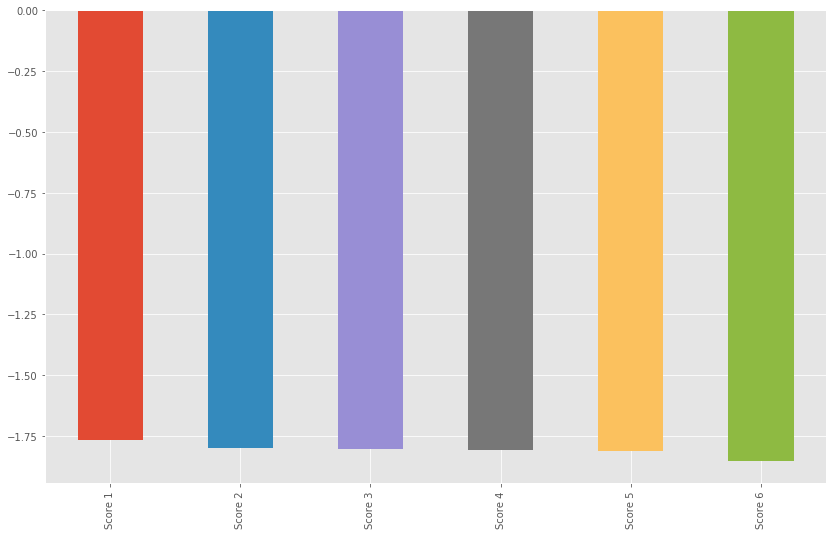

In [62]:
topic_coherence = []
topic_words = pd.DataFrame()
for t in range(len(coherence)):
    label = topic_labels[t]
    topic_coherence.append(coherence[t][1])
    df = pd.DataFrame(coherence[t][0], columns=[(label, 'prob'), (label, 'term')])
    df[(label, 'prob')] = df[(label, 'prob')].apply(lambda x: '{:.2%}'.format(x))
    topic_words = pd.concat([topic_words, df], axis=1)
                      
topic_words.columns = pd.MultiIndex.from_tuples(topic_words.columns)
pd.set_option('expand_frame_repr', False)
print(topic_words.head())
pd.Series(topic_coherence, index=topic_labels).plot.bar();

### Using `gensim` `Dictionary` 

In [63]:
docs = [d.split() for d in train_docs.essay.tolist()]
docs = [[t for t in doc if t not in stop_words] for doc in docs]

In [64]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)

In [65]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [66]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2000
Number of documents: 1620


In [67]:
num_topics = 6
chunksize = 500
passes = 20
iterations = 400
eval_every = None # Don't evaluate model perplexity, takes too much time.

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [68]:
%%time
model = LdaModel(corpus=corpus,
                 id2word=id2word,
                 chunksize=chunksize,
                 alpha='auto',
                 eta='auto',
                 iterations=iterations,
                 num_topics=num_topics,
                 passes=passes, 
                 eval_every=eval_every)

Wall time: 27.8 s


In [69]:
model.show_topics()

[(0,
  '0.016*"information" + 0.007*"help" + 0.007*"students" + 0.007*"public" + 0.006*"Books" + 0.006*"history" + 0.006*"learning" + 0.005*"literary" + 0.005*"These" + 0.005*"A"'),
 (1,
  '0.028*"@CAPS4" + 0.009*"u" + 0.008*"it\'s" + 0.007*"got" + 0.007*"use" + 0.007*"life" + 0.007*"@PERSON1" + 0.006*"buy" + 0.006*"come" + 0.006*"@CAPS9"'),
 (2,
  '0.012*"stuff" + 0.011*"little" + 0.009*"@CAPS3" + 0.008*"school" + 0.007*"kid" + 0.007*"kind" + 0.006*"words" + 0.006*"alot" + 0.006*"@ORGANIZATION1" + 0.006*"thats"'),
 (3,
  '0.012*"section" + 0.011*"adult" + 0.009*"content" + 0.009*"check" + 0.008*"public" + 0.008*"items" + 0.008*"parent" + 0.008*"Libraries" + 0.007*"place" + 0.007*"inappropriate"'),
 (4,
  '0.013*"offended" + 0.010*"offensive," + 0.009*"doesn\'t" + 0.008*"opinion" + 0.008*"it\'s" + 0.008*"taking" + 0.007*"You" + 0.007*"can\'t" + 0.007*"Everyone" + 0.007*"wouldn\'t"'),
 (5,
  '0.012*"freedom" + 0.010*"Censorship" + 0.010*"censor" + 0.009*"censored" + 0.007*"media" + 0.00

### Evaluating Topic Assignments on the Test Set

In [70]:
docs_test = [d.split() for d in test_docs.essay.tolist()]
docs_test = [[t for t in doc if t not in stop_words] for doc in docs_test]

test_dictionary = Dictionary(docs_test)
test_dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)
test_corpus = [dictionary.doc2bow(doc) for doc in docs_test]

In [71]:
gamma, _ = model.inference(test_corpus)
topic_scores = pd.DataFrame(gamma)
topic_scores.head(10)

,0,1,2,3,4,5
0,17.48,0.05,20.02,9.96,0.16,21.09
1,21.83,3.07,2.46,6.35,0.16,64.88
2,10.91,28.50,69.91,0.14,0.16,0.14
3,0.09,9.18,0.18,26.34,64.82,0.14
4,38.97,8.87,10.74,17.29,0.16,62.73
5,0.09,0.05,1.83,0.13,4.51,0.14
6,26.74,21.86,48.32,24.25,13.46,0.14
7,7.78,0.05,30.64,2.70,14.28,54.29
8,0.09,32.36,51.33,7.94,13.90,0.14
9,13.87,0.05,0.18,53.64,0.16,37.86


In [72]:
topic_probabilities = topic_scores.div(topic_scores.sum(axis=1), axis=0)
topic_probabilities.head()

,0,1,2,3,4,5
0,0.25,0.00,0.29,0.14,0.00,0.31
1,0.22,0.03,0.02,0.06,0.00,0.66
2,0.10,0.26,0.64,0.00,0.00,0.00
3,0.00,0.09,0.00,0.26,0.64,0.00
4,0.28,0.06,0.08,0.12,0.00,0.45


In [73]:
topic_probabilities.idxmax(axis=1).head(10)

0    5
1    5
2    2
3    4
4    5
5    4
6    2
7    5
8    2
9    3
dtype: int64

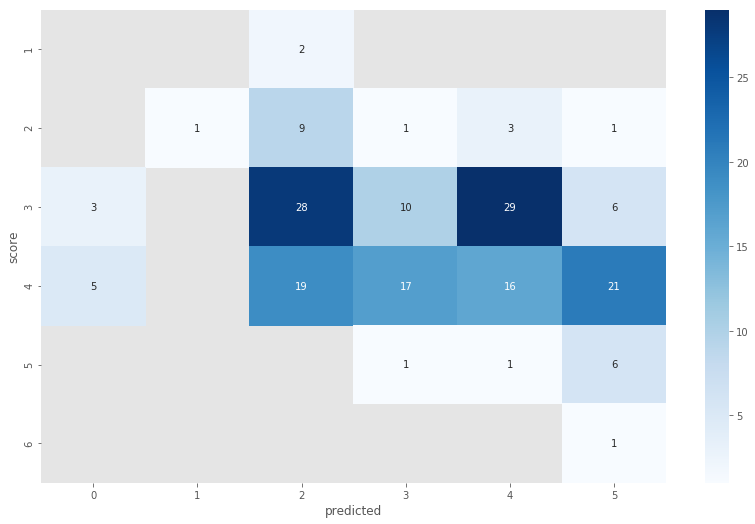

In [75]:
predictions = test_docs.target_score.to_frame('score').assign(predicted=topic_probabilities.idxmax(axis=1).values)
heatmap_data = predictions.groupby('score').predicted.value_counts().unstack()
sns.heatmap(heatmap_data, annot=True, cmap='Blues');